In [42]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tqdm
import random
import pandas as pd
import pickle as pkl
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



Using TensorFlow backend.


In [44]:
fol_dir = '/content/drive/My Drive/Vision_task_dataset_public/'
os.listdir(fol_dir)

['train_image.pkl',
 'train_label.pkl',
 'test_image.pkl',
 'hitkul(sample_submission).csv']

In [0]:
with open(fol_dir+'train_image.pkl', 'rb') as f:
    train_image = pkl.load(f)
with open(fol_dir+'train_label.pkl', 'rb') as f:
    train_label = pkl.load(f)

In [176]:
print(len(train_image), " ", len(train_label))

8000   8000


In [177]:
len(train_image[0])


784

6


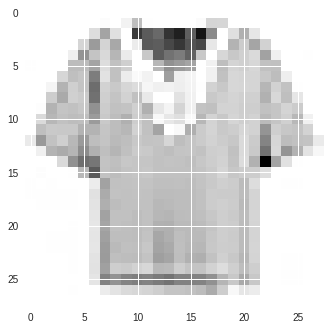

6


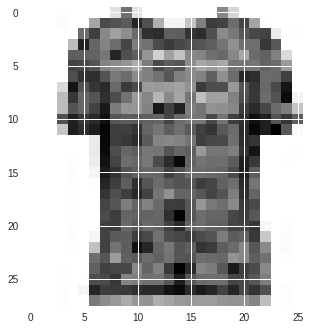

2


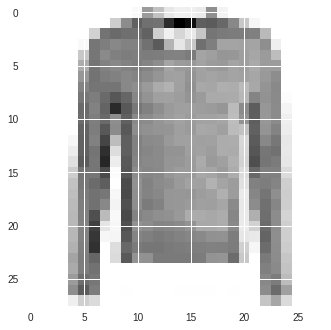

6


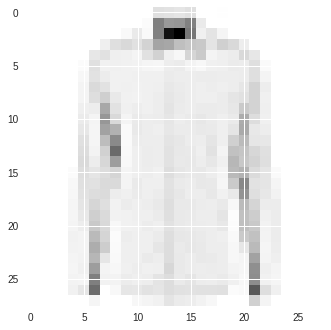

0


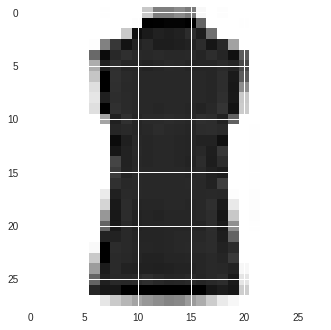

0


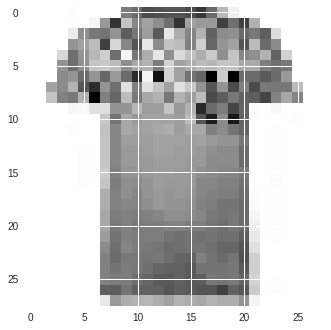

6


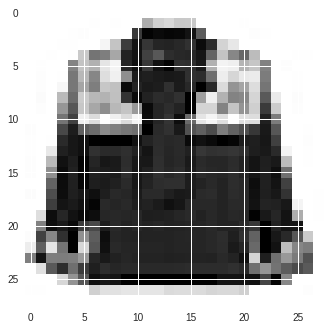

2


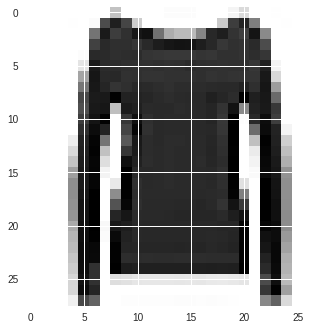

6


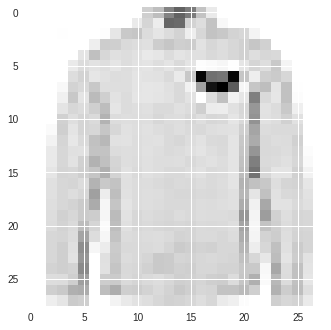

0


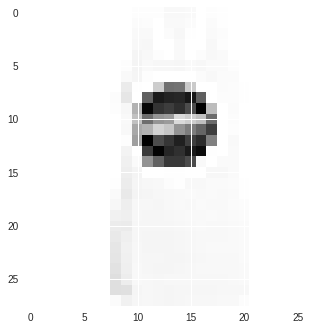

3


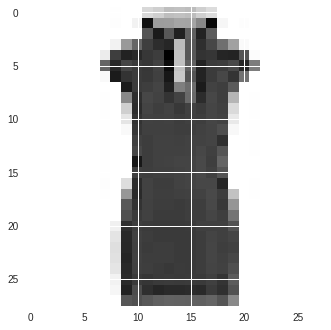

0


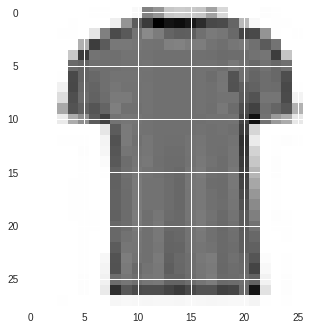

6


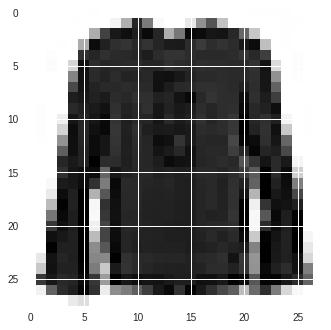

6


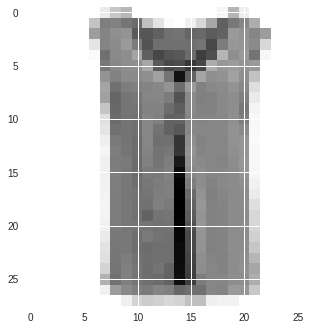

0


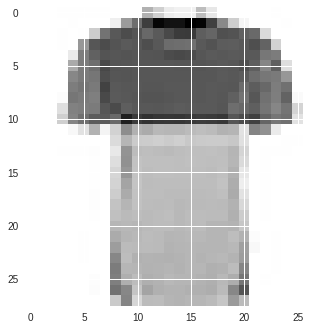

0


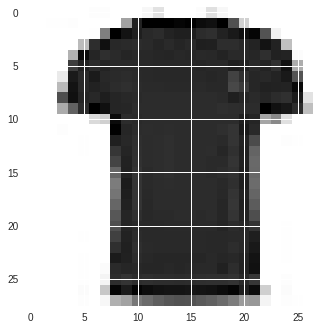

2


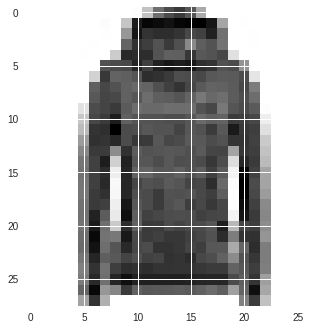

2


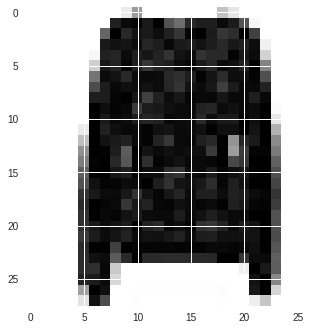

0


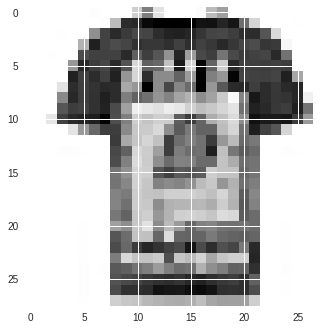

3


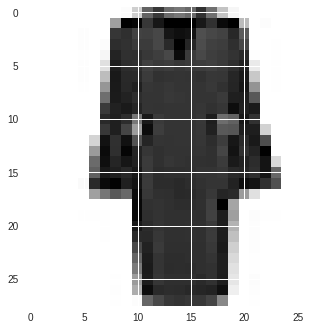

In [178]:
rnd_lst = random.sample(range(0, 8000), 8000)
for i in range(20):
  x = np.asarray(train_image[rnd_lst[i]])
  x = np.reshape(x, (28,28))
  print(train_label[rnd_lst[i]])
  plt.imshow(x); plt.show()

In [0]:
X_train = []
y_train =[]
X_test =[]
y_test = []
for i in range(0, 6000):
    x = np.array(train_image[rnd_lst[i]])
    x = x/255.0
    X_train.append(x)
    y_train.append(train_label[rnd_lst[i]])

for i in range(6000, 8000):
    x = np.array(train_image[rnd_lst[i]])
    x = x/255.0
    X_test.append(x)
    y_test.append(train_label[rnd_lst[i]])



/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


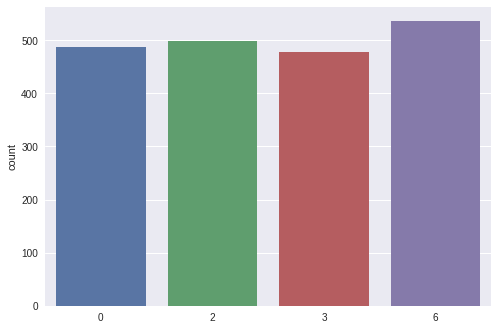

In [180]:
import seaborn as sns
g = sns.countplot(y_test)


In [0]:
for i in range(0, 6000):
    X_train[i] = X_train[i].reshape( 28, 28, 1)

for i in range(0, 2000):
    X_test[i] = X_test[i].reshape( 28, 28, 1)
  
for i in range(0, 6000):
    if(y_train[i] == 6):
        y_train[i] = 0
for i in range(0, 2000):
    if(y_test[i] == 6):
        y_test[i] = 0
  

In [0]:
y_train = to_categorical(y_train, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)

In [183]:
y_train[0].shape

(4,)

In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [0]:
random_seed  =2

In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))

In [0]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [0]:
epochs = 30
batch_size = 86

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [191]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 49s - loss: 0.7285 - acc: 0.6657 - val_loss: 0.4580 - val_acc: 0.7965
Epoch 2/30
 - 47s - loss: 0.5089 - acc: 0.7783 - val_loss: 0.4158 - val_acc: 0.8225
Epoch 3/30
 - 47s - loss: 0.4690 - acc: 0.8043 - val_loss: 0.3995 - val_acc: 0.8285
Epoch 4/30
 - 47s - loss: 0.4416 - acc: 0.8128 - val_loss: 0.3493 - val_acc: 0.8565
Epoch 5/30
 - 47s - loss: 0.4105 - acc: 0.8292 - val_loss: 0.3551 - val_acc: 0.8460
Epoch 6/30
 - 48s - loss: 0.3820 - acc: 0.8459 - val_loss: 0.3247 - val_acc: 0.8675
Epoch 7/30
 - 47s - loss: 0.3618 - acc: 0.8535 - val_loss: 0.2836 - val_acc: 0.8890
Epoch 8/30
 - 47s - loss: 0.3556 - acc: 0.8616 - val_loss: 0.2949 - val_acc: 0.8750
Epoch 9/30
 - 47s - loss: 0.3352 - acc: 0.8684 - val_loss: 0.2643 - val_acc: 0.8950
Epoch 10/30
 - 47s - loss: 0.3329 - acc: 0.8717 - val_loss: 0.2931 - val_acc: 0.8750
Epoch 11/30
 - 47s - loss: 0.3002 - acc: 0.8840 - val_loss: 0.2552 - val_acc: 0.8980
Epoch 12/30
 - 47s - loss: 0.3128 - acc: 0.8785 - val_loss: 0.2611 - val_a

In [0]:
model.save('/content/drive/My Drive/MIDASTASKMODEL.h5')

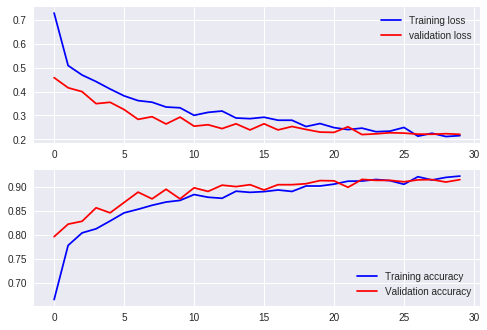

In [193]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
with open(fol_dir+'test_image.pkl', 'rb') as f:
    test_image = pkl.load(f)


In [201]:
len(test_image)

2000

In [0]:
testX =[]
for i in range(0, 2000):
    x = np.array(train_image[rnd_lst[i]])
    x = x/255.0
    x = x.reshape( 28, 28, 1)
    testX.append(x)
testX = np.array(testX)

In [0]:
testy = model.predict(testX)

In [0]:
testy_pred = []
for i in range(0, len(testy)):
    testy_pred.append(np.argmax(testy[i]))
   

In [213]:
testy_pred[:10]

[0, 0, 2, 0, 0, 0, 0, 2, 0, 0]

In [0]:
dict_lst =[]
for i in range(0, len(testy)):
    testy_pred = np.argmax(testy[i])
    if(testy_pred == 0):
        testy_pred = 6
    dict_tmp = {'image_index':i, 'class':testy_pred}
    dict_lst.append(dict_tmp)
    

In [0]:
df = pd.DataFrame(dict_lst)

In [219]:
df

,class,image_index
0,6,0
1,6,1
2,2,2
3,6,3
4,6,4
5,6,5
6,6,6
7,2,7
8,6,8
9,6,9


In [0]:
df.to_csv('/content/drive/My Drive/submission_file.csv', index = False)